In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf

import sys
sys.path.append("..")
from utils import *

In [16]:
data_URL = 'https://www.ssb.no/statbank/sq/10085910'

salmon_data = import_salmon_data(data_URL, rename_cols=True)

commodity_data = yf.download(['ZW=F', 'ZS=F', 'HE=F'],
    start=salmon_data.index[0], 
    end=salmon_data.index[-1], 
    interval='1wk', 
    progress=False
)['Adj Close']

data = pd.concat([salmon_data, commodity_data.reindex(salmon_data.index)], axis=1).dropna()

display(data)

pd.save_csv('supply_data.csv')

,Price,Volume,HE=F,ZS=F,ZW=F
uke,,,,,
2002-03-04,22.73,5140,58.049999,451.00,272.00
2002-03-11,23.05,5121,55.075001,467.50,279.00
2002-03-18,23.57,5765,52.950001,461.25,281.50
2002-03-25,23.94,6336,51.875000,473.50,294.50
2002-04-01,23.79,3748,45.974998,460.50,278.75
...,...,...,...,...,...
2023-07-24,86.14,19604,103.199997,1486.75,704.25
2023-07-31,83.28,20469,101.025002,1444.00,633.00
2023-08-07,80.26,21060,102.099998,1401.25,626.75


# Supply

### Fish Feed

- Soybean
- Wheat
- Fishmeal

,Price,Volume
uke,,
2000-01-17,31.03,4043
2000-01-24,30.95,3730
2000-01-31,31.30,3831
2000-02-07,32.53,4415
2000-02-14,32.46,4617


<BarContainer object of 52 artists>

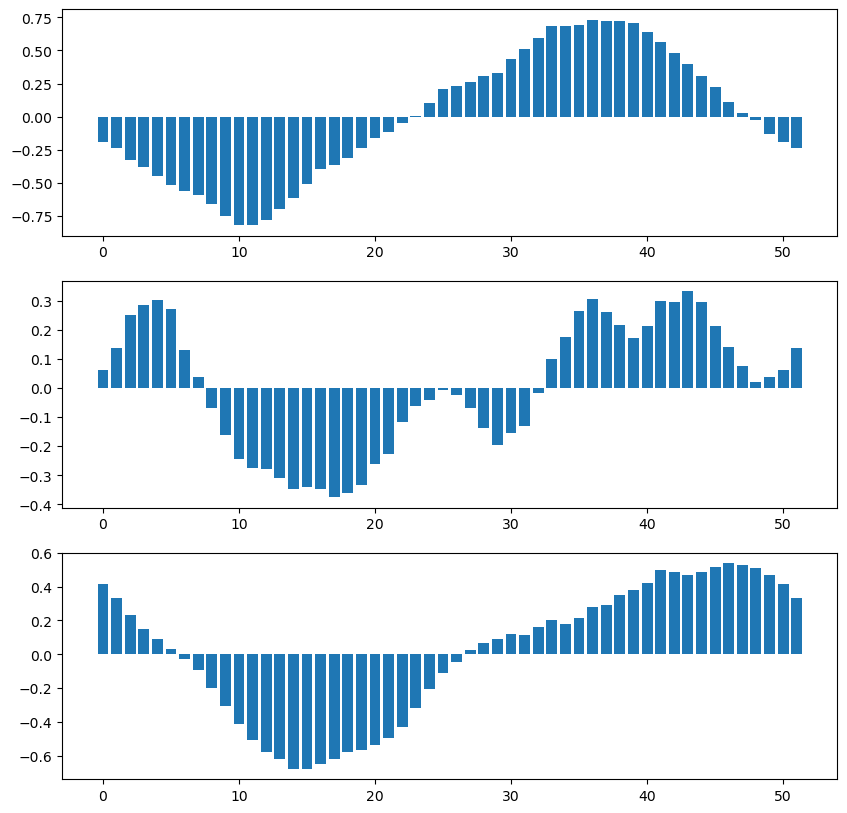

In [24]:

def STL(data: pd.DataFrame, period: int=50):
    seasonal = seasonal_decompose(
        data, model="multiplicative", period=period
    )
    return seasonal

display(salmon_data.head())

models = {
    'Salmon': STL(data['Price'], period=50),
    'ZW=F': STL(data['ZW=F'], period=50), # Wheat
    'ZS=F': STL(data['ZS=F'], period=50), # Soybean
    'HE=F': STL(data['HE=F'], period=50), # Lean Hogs
}

# for i, model in models.items():


cross_corr_ZW = ccf(models['Salmon'].seasonal, models['ZW=F'].seasonal)
cross_corr_ZS = ccf(models['Salmon'].seasonal, models['ZS=F'].seasonal)
cross_corr_HE = ccf(models['Salmon'].seasonal, models['HE=F'].seasonal)

fig, axs = plt.subplots(3,figsize=(10, 10))

axs[0].bar(range(52), cross_corr_ZW[:52])
axs[1].bar(range(52), cross_corr_ZS[:52])
axs[2].bar(range(52), cross_corr_HE[:52])

## Demand

### substitute goods

- Poultry
- Pork
- Beef

### currency

- EUR/NOK